In [1]:
import pandas as pd 
import yfinance as yf
import numpy as np
import scipy.stats as scs
from scipy.stats import randint,norm
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook','grid'])
#plt.style.use('science')
%matplotlib inline

import datetime as dt
from pandas.plotting import scatter_matrix

import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import normal_ad, het_arch
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro

# Phase 1: Exploratory Data Analysis (EDA) of the Assets

## Steps performed

### 1. Data Download
- Collection of historical data for the selected assets.

### 2. Dataset Description
- Preliminary analysis of the downloaded dataset (size, variables, data frequency).

### 3. Statistical Plots
- Visualization of the main descriptive statistics through graphs.

### 4. Autocorrelation Analysis
- Computation and visualization of the autocorrelation function (ACF).
- Analysis performed on both returns and squared returns.

### 5. Statistical Tests
- **Augmented Dickey-Fuller (ADF) test**  
- **Jarque-Bera test**  
- **Shapiro-Wilk test**  
- **Engle’s ARCH test**  
- **Anderson-Darling test**

### 6. Correlation Analysis
- Computation of static correlation between assets.
- Rolling dynamic correlation to assess time-varying relationships.

### 7. Cross-Correlation
- Study of cross-correlations among the different asset returns.




In [2]:
def calculate_metrics(dff):
    log_ret = np.log(dff) - np.log(dff).shift(1)
    avg_ret = log_ret.mean() * 252
    log_std=log_ret.rolling(30).std()
    avg_std=log_ret.std()*np.sqrt(252)
    z=norm.ppf(0.05)
    #VaR parametrico 
    var95_p=-(avg_ret+z*avg_std)
    #VaR empirico 
    var95_e = -log_ret.quantile(0.05)
    es95_p=log_ret[log_ret<log_ret.quantile(0.05)].mean()*252
    DD= dff/dff.cummax()-1
    max_DD=DD.min()
    downside_std=log_ret[log_ret<0].std()*np.sqrt(252) #standard deviation dei soli rendimenti negativi

    return log_ret,avg_ret,log_std, avg_std, var95_p,var95_e, es95_p, max_DD, downside_std

def get_data(tickers,start,end):
    df=yf.download(tickers,start=start,end=end,interval='1d',group_by='ticker')
    df = df.xs('Close', axis=1, level=1) #serve ad accedere al livello corretto del dataset da quando yfinance è stato aggiornato
    return df


def describestat(array):
    p = scs.describe(array)
    results = {
        "size":     p[0],
        "min":      p[1][0],
        "max":      p[1][1],
        "mean":     p[2],
        "std":      p[3],
        "skewness": p[4],
        "kurtosis": p[5],
    }
    # opzionale: stampa
    print("statistic values")
    for k,v in results.items():
        print(f"{k:>12} {v:15.5f}")
    return results

In [3]:
tickers=['PEP','GOOGL','AMZN','NVDA'] #choose the tickers you prefer
end=dt.datetime.now()
start=end-dt.timedelta(days=4000)
df=get_data(tickers,start,end)
df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


Ticker,NVDA,GOOGL,AMZN,PEP
Date,,,,
2014-09-18,0.464541,29.685465,16.250000,67.988358
2014-09-19,0.455939,30.089542,16.566000,68.294189
2014-09-22,0.451399,29.685465,16.225000,68.141266
2014-09-23,0.449487,29.382780,16.181499,67.667984
2014-09-24,0.452115,29.742624,16.410500,68.083046
...,...,...,...,...
2025-08-25,179.809998,208.490005,227.940002,148.199997
2025-08-26,181.770004,207.139999,228.710007,147.000000
2025-08-27,181.600006,207.479996,229.119995,147.639999


In [4]:
df.isna().sum() 
# check the na values

Ticker
NVDA     0
GOOGL    0
AMZN     0
PEP      0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2754 entries, 2014-09-18 to 2025-08-29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NVDA    2754 non-null   float64
 1   GOOGL   2754 non-null   float64
 2   AMZN    2754 non-null   float64
 3   PEP     2754 non-null   float64
dtypes: float64(4)
memory usage: 107.6 KB


In [6]:
df.describe()

Ticker,NVDA,GOOGL,AMZN,PEP
count,2754.000000,2754.000000,2754.000000,2754.000000
mean,27.307301,86.504538,105.603321,117.359994
std,42.322881,48.511710,60.087288,34.276997
min,0.401217,24.704836,14.347500,66.109718
25%,3.415122,46.822066,48.067501,87.005184
50%,6.770607,67.428112,95.854248,114.978222
75%,25.436984,128.325394,159.218994,151.941525
max,183.160004,212.910004,242.059998,182.348969


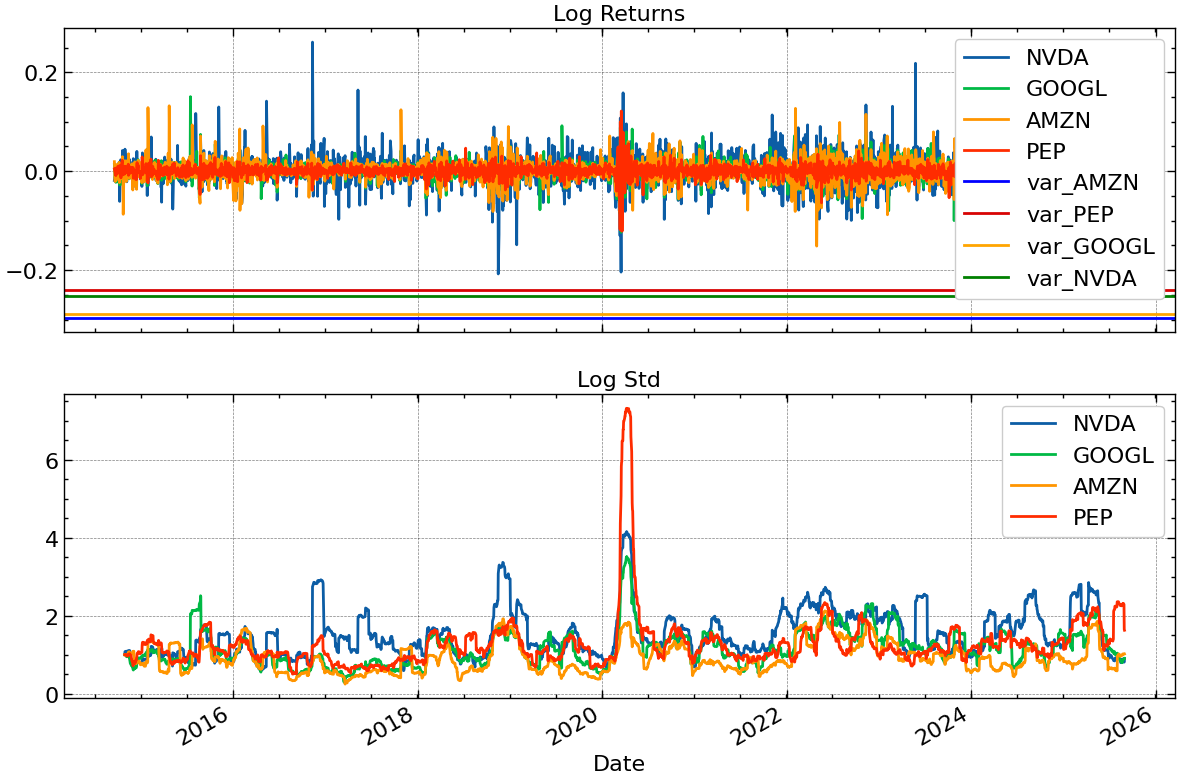

In [7]:
log_ret,avg_ret,log_std,avg_std,var95,var95_e,es,maxdd,down_std= calculate_metrics(df)
log_ret_clean = log_ret.replace([np.inf, -np.inf], np.nan).dropna()
log_std_clean=log_std.replace([np.inf, -np.inf], np.nan).dropna()

#Plotted Gaussian assumptions only. It should be compared with the empricial ones computed above to 
#show how the parametric normality framework does not work.
fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)
log_ret_clean.plot(ax=axes[0], title="Log Returns")
axes[0].axhline(-var95.loc['AMZN'],label='var_AMZN',color='blue')
axes[0].axhline(-var95.loc['PEP'],label='var_PEP',color="#D70303")
axes[0].axhline(-var95.loc['GOOGL'],label='var_GOOGL',color='orange')
axes[0].axhline(-var95.loc['NVDA'],label='var_NVDA',color='green')
axes[0].legend()

(log_std_clean/log_std_clean.iloc[0]).plot(ax=axes[1], title="Log Std") #indicizzato a 1
plt.tight_layout()
axes[1].legend()

plt.show()


In [8]:
results = {}

for t in tickers:
    log_data = np.array(log_ret_clean[t].dropna())
    results[t] = describestat(log_data)

df_stats = pd.DataFrame.from_dict(results, orient="index")

statistic values
        size      2753.00000
         min        -0.12136
         max         0.12166
        mean         0.00028
         std         0.00014
    skewness        -0.47980
    kurtosis        19.38431
statistic values
        size      2753.00000
         min        -0.12368
         max         0.15065
        mean         0.00072
         std         0.00032
    skewness        -0.00904
    kurtosis         5.94714
statistic values
        size      2753.00000
         min        -0.15140
         max         0.13218
        mean         0.00096
         std         0.00043
    skewness         0.12438
    kurtosis         5.83760
statistic values
        size      2753.00000
         min        -0.20771
         max         0.26088
        mean         0.00215
         std         0.00092
    skewness         0.13848
    kurtosis         7.03938


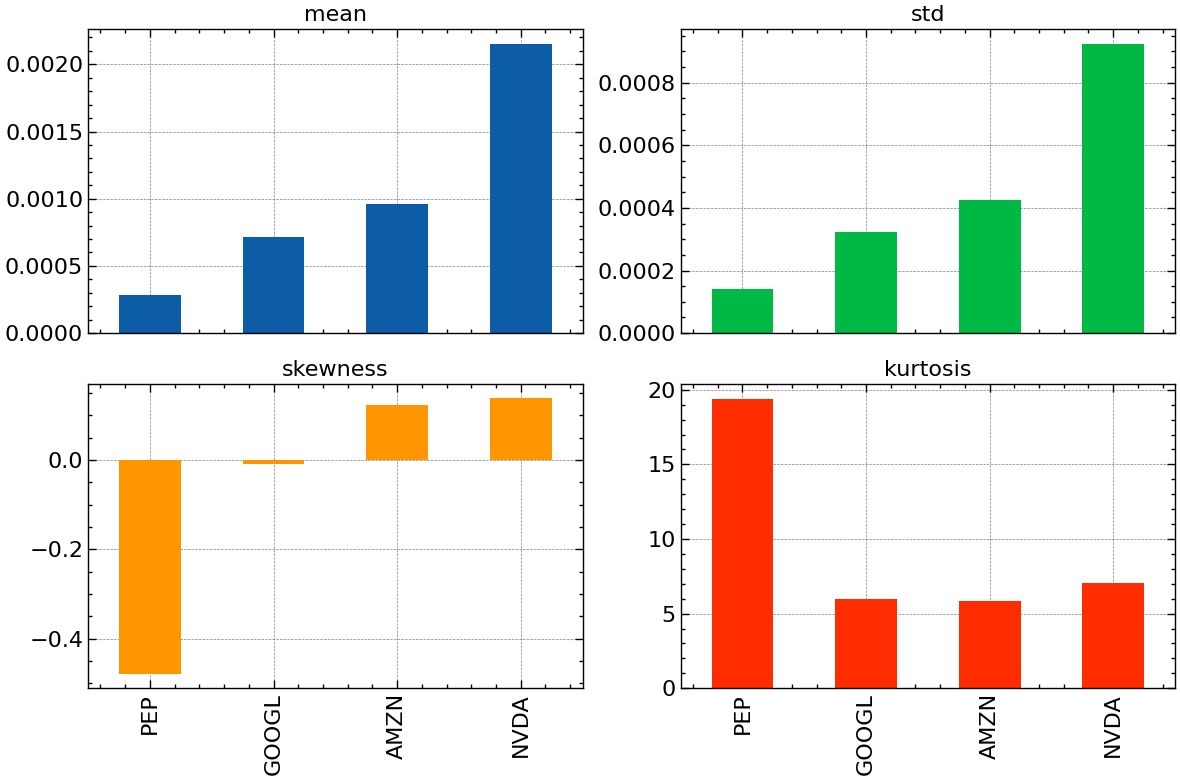

In [9]:
metrics = ["mean","std","skewness","kurtosis"]

# Barplot comparativi
df_stats[metrics].plot(kind="bar", subplots=True, layout=(2,2),
                       figsize=(12,8), legend=False, sharex=True)
plt.tight_layout(); plt.show()



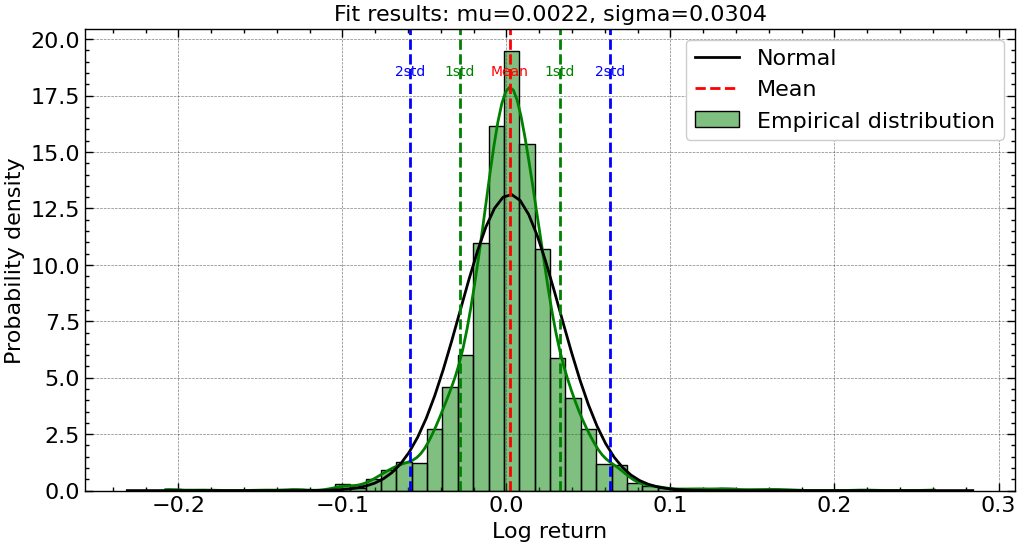

In [10]:
plt.figure(figsize=(12,6))
ret_ = log_ret_clean['NVDA'].dropna()
sns.histplot(ret_, bins=50, kde=True, color='green', stat='density', label='Empirical distribution')
plt.title("Density distribution of log returns")
plt.xlabel("Log return")
plt.ylabel("Probability density")

mu, sigma = norm.fit(ret_)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2, label='Normal')
plt.axvline(mu, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mu+sigma, color='green', linestyle='dashed', linewidth=2)
plt.axvline(mu-sigma, color='green', linestyle='dashed', linewidth=2)
plt.axvline(mu+2*sigma, color='b', linestyle='dashed', linewidth=2)
plt.axvline(mu-2*sigma, color='b', linestyle='dashed', linewidth=2)

plt.text(mu, plt.ylim()[1]*0.9, 'Mean', color='r', ha='center')
plt.text(mu+sigma, plt.ylim()[1]*0.9, '1std', color='g', ha='center')
plt.text(mu-sigma, plt.ylim()[1]*0.9, '1std', color='g', ha='center')
plt.text(mu+2*sigma, plt.ylim()[1]*0.9, '2std', color='b', ha='center')
plt.text(mu-2*sigma, plt.ylim()[1]*0.9, '2std', color='b', ha='center')

title = 'Fit results: mu=%.4f, sigma=%.4f' % (mu, sigma)
plt.title(title)
plt.legend()
plt.show()



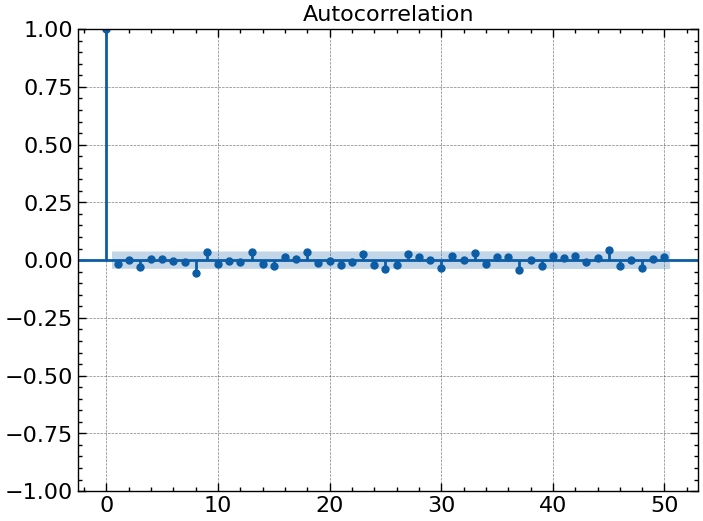

In [11]:
plot_acf(log_ret_clean['AMZN'],lags=50)
plt.show()

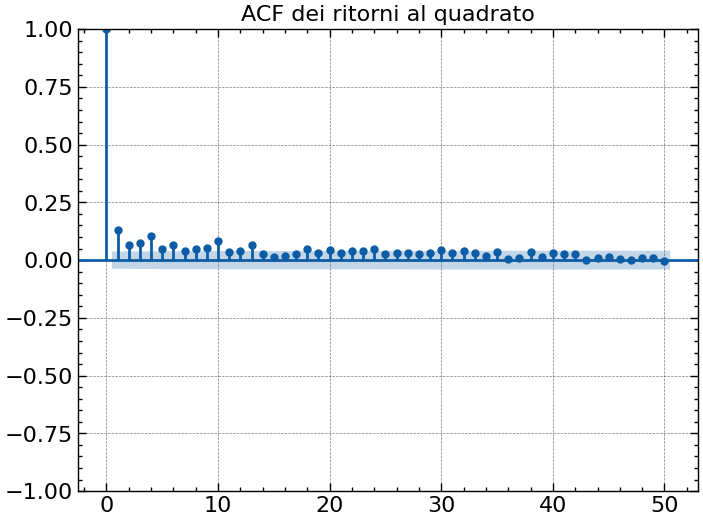

In [12]:
plot_acf(log_ret_clean["AMZN"].dropna()**2, lags=50)
plt.title("ACF dei ritorni al quadrato")
plt.show()

In [13]:
r = log_ret_clean['AMZN']

ad_stat, ad_p = normal_ad(r)
jb_stat, jb_p, jb_skew, jb_kurt = jarque_bera(r)
sh_stat, sh_p = shapiro(r.sample(min(5000, len(r)), random_state=42))

print(f"Anderson–Darling: stat={ad_stat:.4f}, p={ad_p:.4g}")
print(f"Jarque–Bera : stat={jb_stat:.4f}, p={jb_p:.4g} | skew={jb_skew:.3f}, kurt={jb_kurt:.3f}")
print(f"Shapiro–Wilk    : stat={sh_stat:.4f}, p={sh_p:.4g}")

adf_stat, adf_p, adf_lags, adf_n, adf_crit, *_ = adfuller(r, autolag="AIC")
print(f"\nADF test: stat={adf_stat:.4f}, p={adf_p:.4g}, lags={adf_lags}, n={adf_n}")
print(f"Critical values: {adf_crit}")

arch_stat, arch_p, arch_lags, _ = het_arch(r, nlags=20)
print(f"\nARCH LM (20 lags): stat={arch_stat:.4f}, p={arch_p:.4g}, used_lags={arch_lags}")


Anderson–Darling: stat=33.3709, p=0
Jarque–Bera : stat=3916.0784, p=0 | skew=0.124, kurt=8.838
Shapiro–Wilk    : stat=0.9335, p=2.182e-33

ADF test: stat=-53.4318, p=0, lags=0, n=2752
Critical values: {'1%': -3.432728419350374, '5%': -2.8625908153358632, '10%': -2.5673293825262387}

ARCH LM (20 lags): stat=112.9112, p=5.768e-15, used_lags=5.84360313608218


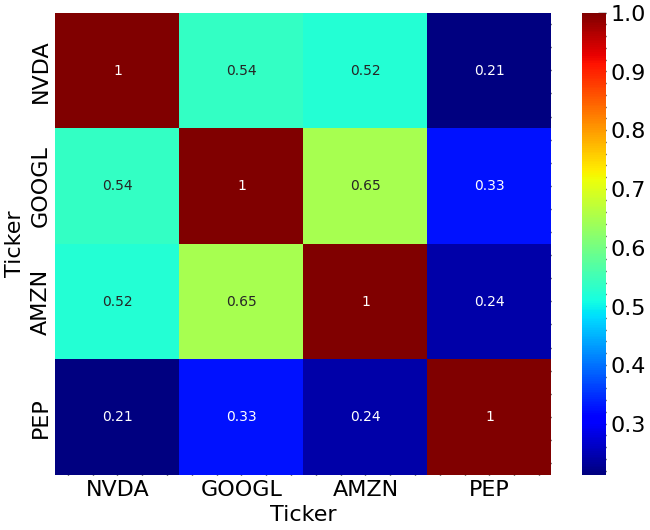

In [14]:
#let's see the assets correlations
corr= log_ret_clean.corr()
sns.heatmap(corr,annot=True,cmap='jet')
plt.show()

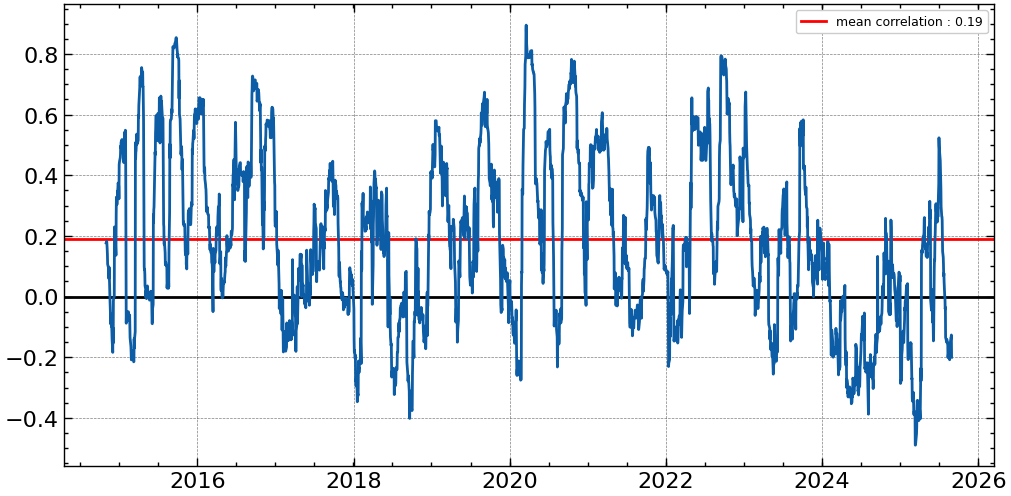

In [15]:
#rolling correlation
window=30
rolling=[]
for i in range(window,len(log_ret_clean)):
    w=log_ret_clean.iloc[i-window:i].corr()
    rolling.append(w)
date=log_ret_clean.index
rolling_dates=date[window:]

corr_mat = [mat["AMZN"]["PEP"] for mat in rolling]
plt.figure(figsize=(12,6))
plt.axhline(np.mean(corr_mat),color='red',label=f"mean correlation : {np.round(np.mean(corr_mat),2)}")
plt.axhline(0,color='black')
plt.plot(rolling_dates,corr_mat,'-')
plt.legend(fontsize=9)
plt.show()


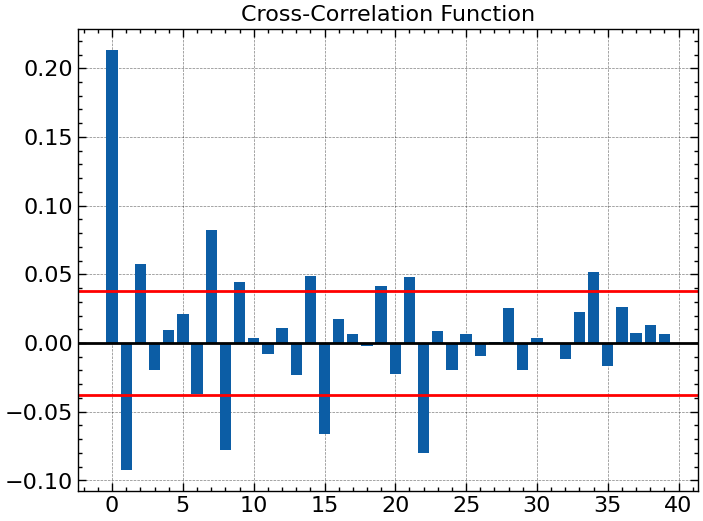

In [16]:
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt

N=len(log_ret_clean)
x = log_ret_clean["PEP"].dropna()
y = log_ret_clean["NVDA"].dropna()

ccf_vals = ccf(x, y)[:40]  # fisrt 40 lags
plt.bar(range(len(ccf_vals)), ccf_vals)
plt.axhline(0, color='k')
plt.axhline(2/np.sqrt(N), color='red')
plt.axhline(-2/np.sqrt(N), color='red')
plt.title("Cross-Correlation Function")
plt.show()

# Second Phase : Preprocessing 

In [17]:

# log Realized volatility with windows of 5,15,30
h1=5
h2=15
h3=30
log_realized_volatility_5= np.log(log_ret_clean.rolling(h1).std()).dropna()
log_realized_volatility_15= np.log(log_ret_clean.rolling(h2).std()).dropna()
log_realized_volatility_30= np.log(log_ret_clean.rolling(h3).std()).dropna()


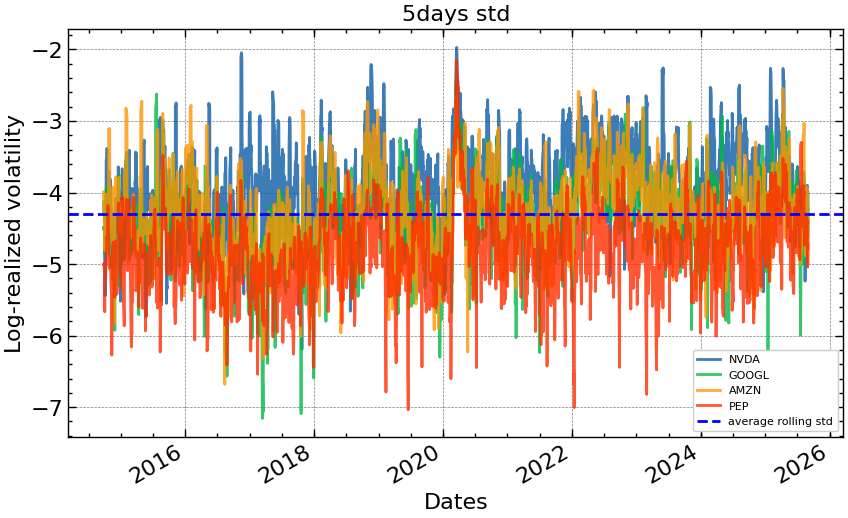

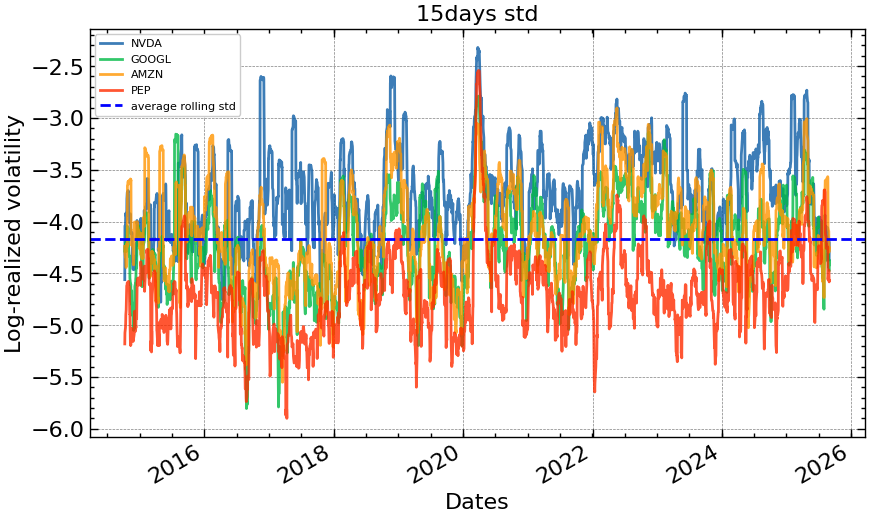

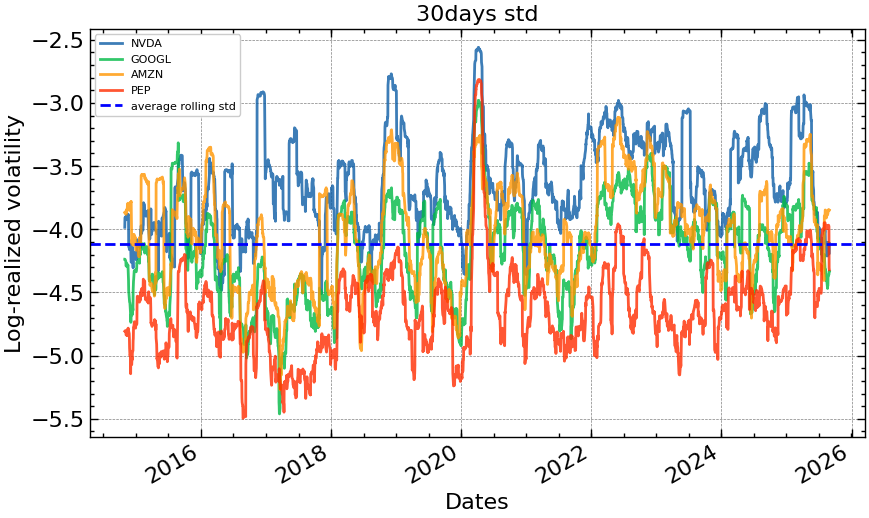

In [18]:
log_realized_volatility_5.plot(title='5days std',figsize=(10,6),alpha=0.8)
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Log-realized volatility')
plt.axhline(np.mean(log_realized_volatility_5),linestyle='--',color='blue',label=f"average rolling std")
plt.legend(fontsize=8)
plt.show()
log_realized_volatility_15.plot(title='15days std',figsize=(10,6),alpha=0.8)
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Log-realized volatility')
plt.axhline(np.mean(log_realized_volatility_15),linestyle='--',color='blue',label=f"average rolling std")
plt.legend(fontsize=8)
plt.show()
log_realized_volatility_30.plot(title='30days std',figsize=(10,6),alpha=0.8)
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Log-realized volatility')
plt.axhline(np.mean(log_realized_volatility_30),linestyle='--',color='blue',label=f"average rolling std")
plt.legend(fontsize=8)
plt.show()



In [19]:
# ATR 
dfs=[]
tickers=['PEP','GOOGL','AMZN','NVDA']
df=yf.download(tickers,start=start,end=end,interval='1d',group_by='ticker')
for i in tickers:
    dff=df[i]
    dfs.append(dff)


[*********************100%***********************]  4 of 4 completed


In [20]:
df_pep=dfs[0]
df_googl=dfs[1]
df_AMZN=dfs[2]
df_NVDA=dfs[3]

In [21]:
def ATR(df,n=14):
    high=df['High']
    low=df['Low']
    close=df['Close']

    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # ATR iniziale 
    atr = pd.Series(np.nan, index=df.index)
    atr.iloc[n-1] = tr.iloc[:n].mean()

    
    for i in range(n, len(tr)):
        atr.iloc[i] = (atr.iloc[i-1] * (n-1) + tr.iloc[i]) / n

    return atr

In [22]:
pep_atr=pd.DataFrame(ATR(df_pep).dropna())
googl_atr=pd.DataFrame(ATR(df_googl).dropna())
#googl_atr.reset_index(inplace=True)
amzn_atr=pd.DataFrame(ATR(df_AMZN).dropna())
#amzn_atr.reset_index(inplace=True)
nvda_atr=pd.DataFrame(ATR(df_NVDA).dropna())
#nvda_atr.reset_index(inplace=True)


In [23]:
pep_atr.columns=['PEP_ATR']
pep_atr.reset_index(inplace=True)
googl_atr.columns=['GOOGL_ATR']
googl_atr.reset_index(inplace=True)
amzn_atr.columns=['AMZN_ATR']
amzn_atr.reset_index(inplace=True)
nvda_atr.columns=['NVDA_ATR']
nvda_atr.reset_index(inplace=True)


# Merge alltoghether
atr_pep_googl=pd.merge(pep_atr,googl_atr,how='inner',on='Date')
atr_nvda_amzn=pd.merge(nvda_atr,amzn_atr,how='inner',on='Date')
df_atr_final=pd.merge(atr_nvda_amzn,atr_pep_googl,how='inner',on='Date')
df_atr_final.set_index('Date')


,NVDA_ATR,AMZN_ATR,PEP_ATR,GOOGL_ATR
Date,,,,
2014-10-07,0.009132,0.325821,0.578887,0.434040
2014-10-08,0.009469,0.338156,0.598911,0.463567
2014-10-09,0.009647,0.343216,0.694483,0.482677
2014-10-10,0.010784,0.341522,0.766064,0.519984
2014-10-13,0.010918,0.351877,0.795603,0.541242
...,...,...,...,...
2025-08-25,4.709296,4.993071,2.586480,4.532006
2025-08-26,4.628633,4.849280,2.576018,4.407577
2025-08-27,4.540159,4.650045,2.497730,4.325608


In [24]:
# altre features sono i ritorni in modulo

log_ret_abs=np.abs(log_ret_clean)
log_ret_abs.columns=['AMZN_ret_abs','NVDA_ret_abs','GOOGL_ret_abs','PEP_ret_abs']
log_realized_volatility_15.columns=['AMZN_std15','NVDA_std15','GOOGL_std15','PEP_std15']
log_realized_volatility_5.columns=['AMZN_std5','NVDA_std5','GOOGL_std5','PEP_std5']
log_realized_volatility_30.columns=['AMZN_std30','NVDA_std30','GOOGL_std30','PEP_std30']
df1=pd.merge(log_ret_abs,log_realized_volatility_15,how='inner',on='Date')
df2=pd.merge(df1,log_realized_volatility_5,how='inner',on='Date')
df3=pd.merge(df2,log_realized_volatility_30,how='inner',on='Date')
df4=pd.merge(df3,df_atr_final,how='inner',on='Date')
df4.set_index('Date',inplace=True)

In [25]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2724 entries, 2014-10-30 to 2025-08-29
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AMZN_ret_abs   2724 non-null   float64
 1   NVDA_ret_abs   2724 non-null   float64
 2   GOOGL_ret_abs  2724 non-null   float64
 3   PEP_ret_abs    2724 non-null   float64
 4   AMZN_std15     2724 non-null   float64
 5   NVDA_std15     2724 non-null   float64
 6   GOOGL_std15    2724 non-null   float64
 7   PEP_std15      2724 non-null   float64
 8   AMZN_std5      2724 non-null   float64
 9   NVDA_std5      2724 non-null   float64
 10  GOOGL_std5     2724 non-null   float64
 11  PEP_std5       2724 non-null   float64
 12  AMZN_std30     2724 non-null   float64
 13  NVDA_std30     2724 non-null   float64
 14  GOOGL_std30    2724 non-null   float64
 15  PEP_std30      2724 non-null   float64
 16  NVDA_ATR       2724 non-null   float64
 17  AMZN_ATR       2724 non-null   flo

# Preproceesing, solo un asset per ora

In [26]:
df = df4.copy()

h = 10  # future windows

# example for AMZN
X_amzn = df[['AMZN_ret_abs','AMZN_std5','AMZN_std15','AMZN_std30','AMZN_ATR']]

def build_vol_targets_multi_horizon(abs_ret: pd.Series, H: int = 10):
    
    sq = abs_ret.pow(2)
    out = {}
    for k in range(1, H+1):
        rv_k = sq.shift(-1).rolling(window=k, min_periods=k).sum().pow(0.5)
        out[f'h{k}'] = np.log(rv_k.replace(0, np.nan))
    return pd.DataFrame(out)

H = 10
Y_amzn = build_vol_targets_multi_horizon(df['AMZN_ret_abs'], H=H)
data = X_amzn.join(Y_amzn, how='inner').replace([np.inf, -np.inf], np.nan).dropna()
X = data[X_amzn.columns]
Y = data[[f'h{k}' for k in range(1, H+1)]]


from sklearn.preprocessing import StandardScaler

n = len(X)
i_tr  = int(n*0.70)
i_val = int(n*0.85)

X_tr,  X_val,  X_te  = X.iloc[:i_tr],  X.iloc[i_tr:i_val],  X.iloc[i_val:]
Y_tr,  Y_val,  Y_te  = Y.iloc[:i_tr],  Y.iloc[i_tr:i_val],  Y.iloc[i_val:]

scaler = StandardScaler().fit(X_tr)
X_tr_s  = pd.DataFrame(scaler.transform(X_tr),  index=X_tr.index,  columns=X_tr.columns)
X_val_s = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
X_te_s  = pd.DataFrame(scaler.transform(X_te),  index=X_te.index,  columns=X_te.columns)



def make_seq2seq(Xdf, Ydf, seq_len=30):
    Xs, Ys = [], []
    for i in range(seq_len, len(Xdf)):
        Xs.append(Xdf.iloc[i-seq_len:i].values)   # (seq_len, F)
        Ys.append(Ydf.iloc[i-seq_len:i].values)   # (seq_len, H)
    return np.array(Xs, np.float32), np.array(Ys, np.float32)

SEQ_LEN = 60
Xtr_seq,  Ytr_seq  = make_seq2seq(X_tr_s,  Y_tr,  seq_len=SEQ_LEN)
Xval_seq, Yval_seq = make_seq2seq(X_val_s, Y_val, seq_len=SEQ_LEN)
Xte_seq,  Yte_seq  = make_seq2seq(X_te_s,  Y_te,  seq_len=SEQ_LEN)

print(Xtr_seq.shape, Ytr_seq.shape)  # -> (N_tr, seq_len, F), (N_tr, seq_len, H)



(1836, 60, 5) (1836, 60, 10)


# Model construction and fitting


In [27]:
import tensorflow as tf
from tensorflow import keras

F = Xtr_seq.shape[-1]
H = Ytr_seq.shape[-1]


In [28]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2025_08_31-17_11_25'

In [29]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [34]:
model= keras.models.Sequential([
    keras.Input(shape=(SEQ_LEN, F)),
    keras.layers.GRU(64,return_sequences=True),
    keras.layers.Dropout(rate=0.3),
    keras.layers.GRU(32,return_sequences=True),
    keras.layers.Dropout(rate=0.1),
    keras.layers.TimeDistributed(keras.layers.Dense(H))  # output: (seq_len, H) 
])

loss = tf.keras.losses.Huber(delta=0.1)
optimizer = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    clipnorm=1.0  # Gradient clipping per stabilità
)
model.compile(optimizer=optimizer, loss=loss,metrics=['mse','mae','mape'])
es = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=7,min_lr=1e-7) #performance scheduling 
#lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)


tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(
    Xtr_seq, Ytr_seq,
    validation_data=(Xval_seq, Yval_seq),
    epochs=200, batch_size=32, callbacks=[es,tensorboard_cb,lr_scheduler]
)

Epoch 1/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.2000 - mae: 2.0498 - mape: 64.5082 - mse: 5.8198 - val_loss: 0.0550 - val_mae: 0.5983 - val_mape: 20.9080 - val_mse: 0.7429 - learning_rate: 0.0010
Epoch 2/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0605 - mae: 0.6531 - mape: 21.1626 - mse: 0.8064 - val_loss: 0.0376 - val_mae: 0.4223 - val_mape: 14.9435 - val_mse: 0.4294 - learning_rate: 0.0010
Epoch 3/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0492 - mae: 0.5401 - mape: 17.2304 - mse: 0.5794 - val_loss: 0.0280 - val_mae: 0.3248 - val_mape: 11.0636 - val_mse: 0.3164 - learning_rate: 0.0010
Epoch 4/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0432 - mae: 0.4795 - mape: 15.1439 - mse: 0.4779 - val_loss: 0.0263 - val_mae: 0.3071 - val_mape: 10.4143 - val_mse: 0.2856 - learning_rate: 0.0010
Epoch 5/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0403 - mae: 0.4500 - mape: 14.1447 - mse: 0.4294 - val_loss: 0.0249 - val_mae: 0.2928 - val_mape: 

In [35]:
test = model.evaluate(Xte_seq, Yte_seq, verbose=0)
print("Test:", test)


Test: [0.019746284931898117, 0.2200508713722229, 0.23882506787776947, 7.505155563354492]


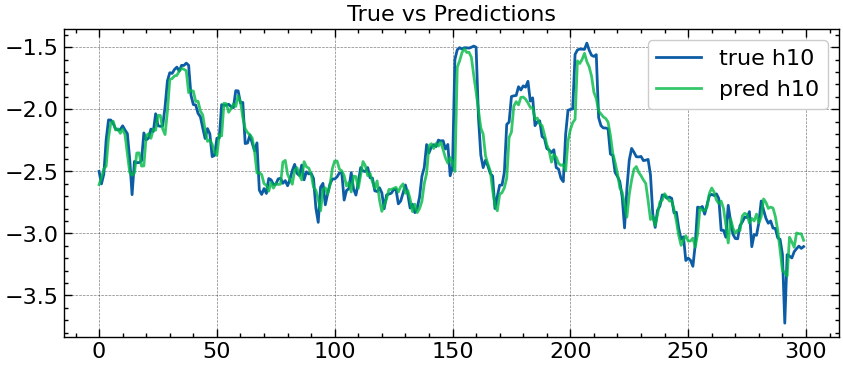

In [36]:
Y_pred = model.predict(Xte_seq, verbose=0)   

h_names = [f"h{k}" for k in range(1, H+1)]
today_true = Yte_seq[-1, -1, :]              

kH = H-1

plt.figure(figsize=(10,4))
plt.plot(Yte_seq[-300:, -1, kH], label=f"true h{H}")
plt.plot(Y_pred[-300:, -1, kH], label=f"pred h{H}", alpha=0.8)
plt.legend(); plt.title(f" True vs Predictions ")
plt.grid(True); plt.show()



Generating predictions...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Predictions shape: (347, 60, 10)

=== TODAY'S PREDICTIONS ===
       true    pred   error  abs_error  pct_error
h1  -4.8402 -4.3200  0.5202     0.5202    10.7465
h2  -4.8332 -4.2308  0.6025     0.6025    12.4650
h3  -4.3087 -3.9537  0.3550     0.3550     8.2400
h4  -4.0825 -3.7790  0.3035     0.3035     7.4343
h5  -3.7303 -3.6541  0.0762     0.0762     2.0439
h6  -3.7253 -3.5483  0.1770     0.1770     4.7510
h7  -3.7237 -3.3966  0.3272     0.3272     8.7858
h8  -3.1457 -3.2497 -0.1039     0.1039     3.3040
h9  -3.1261 -3.1324 -0.0063     0.0063     0.2019
h10 -3.1070 -3.0559  0.0511     0.0511     1.6439

=== CONVERTED VOLATILITIES ===
     true_vol  pred_vol  vol_error
h1     0.0079    0.0133     0.0054
h2     0.0080    0.0145     0.0066
h3     0.0135    0.0192     0.0057
h4     0.0169    0.0228     0.0060
h5     0.0240    0.0259     0.0019
h6     0.0241    0.0288     0.0047
h7     0.0241    0.0335     0.0093
h8     0.043

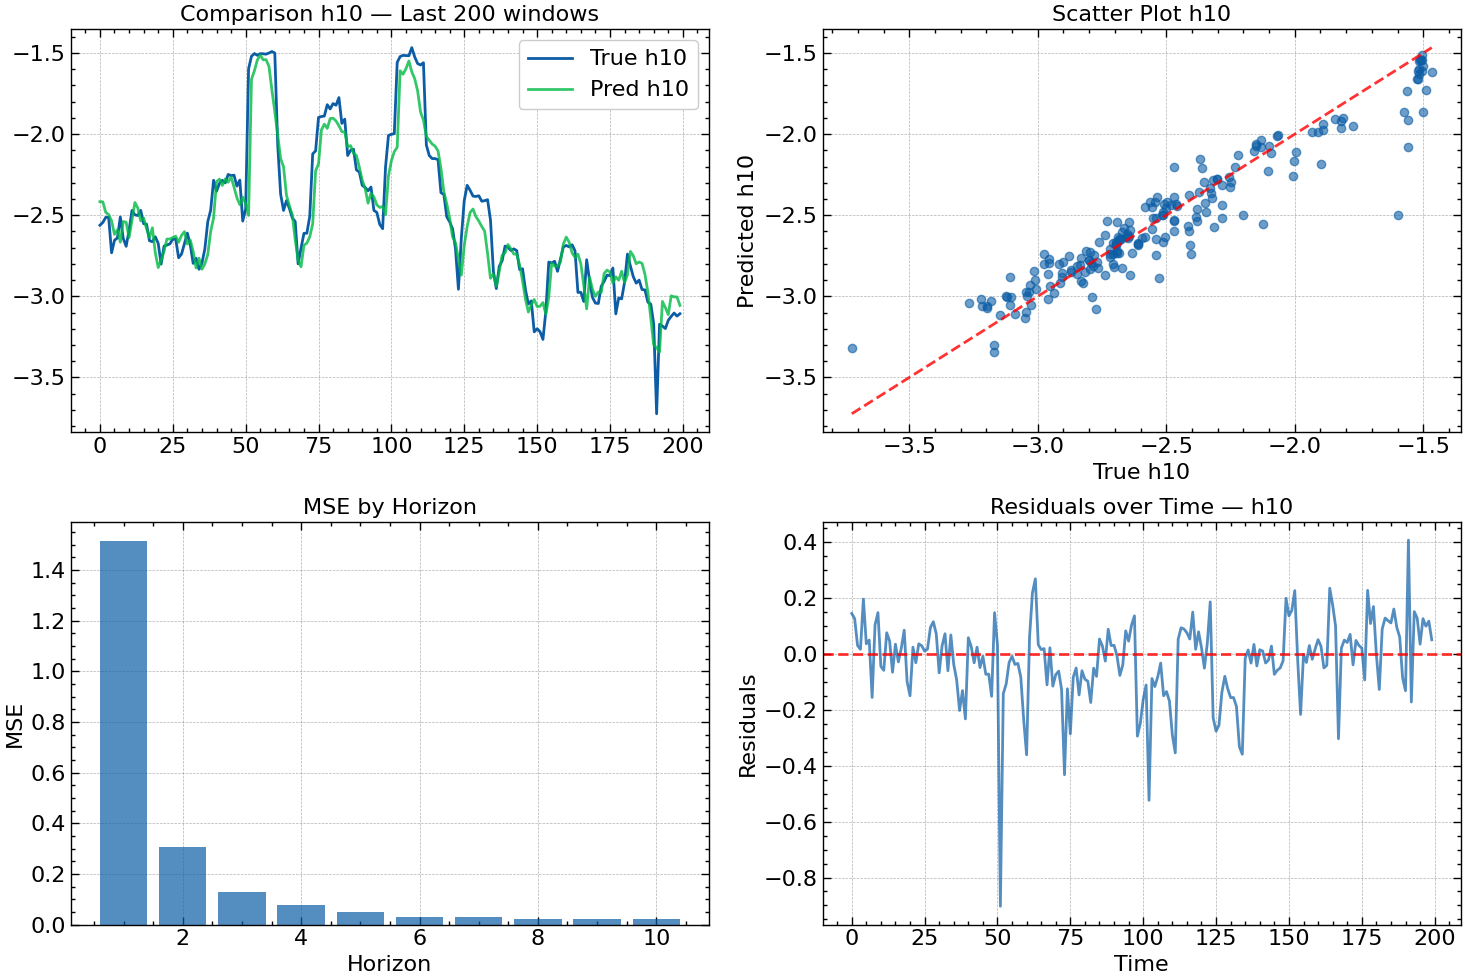


=== ERROR ANALYSIS ===
Mean error h10: -0.0231
Std error h10: 0.1471
Max absolute error h10: 0.9030
Residual normality test (p-value): 0.0000

=== PREDICTION STABILITY ===
Rolling MSE (mean) h1: 1.4637
Rolling MSE (mean) h10: 0.0181
Rolling MSE variance h1: 0.1705
Rolling MSE variance h10: 0.0001

=== CROSS-HORIZON CORRELATIONS ===


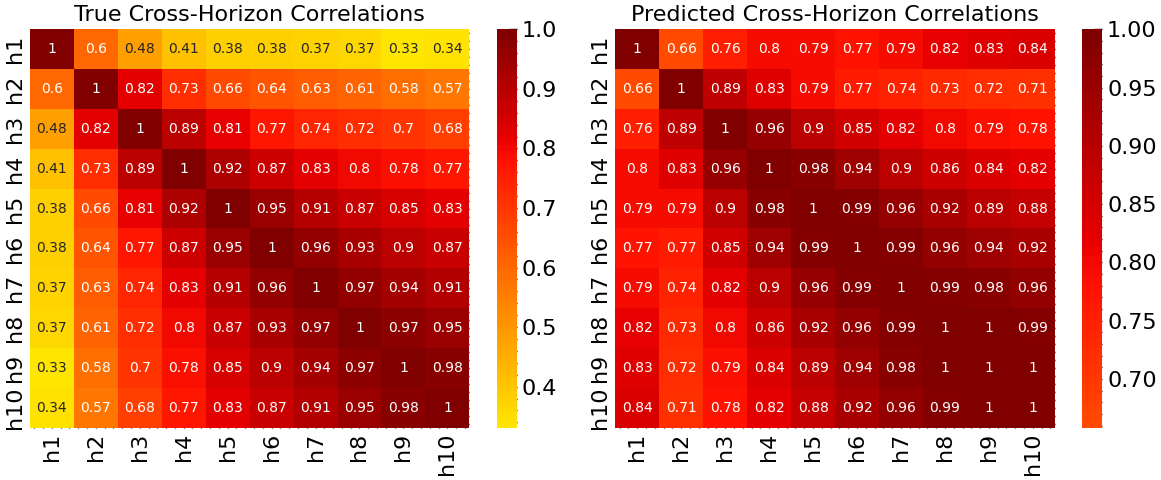


SUMMARY PERFORMANCE
Overall MSE: 0.2201
Overall MAE: 0.2388
Overall MAPE: 7.51%
Best performing horizon: h10 (MSE: 0.0206)
Worst performing horizon: h1 (MSE: 1.5143)


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats


print("Generating predictions...")
Y_pred = model.predict(Xte_seq, verbose=1, batch_size=64)  # Batch size for efficiency
print(f"Predictions shape: {Y_pred.shape}")


h_names = [f"h{k}" for k in range(1, H+1)]
today_true = Yte_seq[-1, -1, :]  # (H,)
today_pred = Y_pred[-1, -1, :]   # (H,)


today_df = pd.DataFrame({
    "true": today_true,
    "pred": today_pred,
    "error": today_pred - today_true,
    "abs_error": np.abs(today_pred - today_true),
    "pct_error": 100 * np.abs(today_pred - today_true) / np.abs(today_true)
}, index=h_names)

print("\n=== TODAY'S PREDICTIONS ===")
print(today_df.round(4))

if np.all(today_true < 0):  # Check if values are in log scale
    today_true_sigma = np.exp(today_true)
    today_pred_sigma = np.exp(today_pred)
    
    sigma_df = pd.DataFrame({
        "true_vol": today_true_sigma,
        "pred_vol": today_pred_sigma,
        "vol_error": today_pred_sigma - today_true_sigma
    }, index=h_names)
    
    print("\n=== CONVERTED VOLATILITIES ===")
    print(sigma_df.round(4))


print("\n=== METRICS BY HORIZON ===")
mse_per_h = ((Y_pred - Yte_seq)**2).mean(axis=(0, 1))              # (H,)
mae_per_h = np.abs(Y_pred - Yte_seq).mean(axis=(0, 1))              # (H,)
mape_per_h = (np.abs((Y_pred - Yte_seq) / Yte_seq) * 100).mean(axis=(0, 1))  # (H,)

r2_per_h = []
for h in range(H):
    y_true_flat = Yte_seq[:, :, h].flatten()
    y_pred_flat = Y_pred[:, :, h].flatten()
    r2_per_h.append(r2_score(y_true_flat, y_pred_flat))

metrics_df = pd.DataFrame({
    "MSE": mse_per_h,
    "MAE": mae_per_h,
    "MAPE": mape_per_h,
    "R2": r2_per_h
}, index=h_names)

print(metrics_df.round(4))

best_horizon_mse = metrics_df['MSE'].idxmin()
worst_horizon_mse = metrics_df['MSE'].idxmax()
print(f"\nBest horizon (MSE): {best_horizon_mse}")
print(f"Worst horizon (MSE): {worst_horizon_mse}")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
kH = H - 1
axes[0, 0].plot(Yte_seq[-200:, -1, kH], label=f"True h{H}", linewidth=2)
axes[0, 0].plot(Y_pred[-200:, -1, kH], label=f"Pred h{H}", alpha=0.8, linewidth=2)
axes[0, 0].set_title(f"Comparison h{H} — Last 200 windows")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)


y_true_last = Yte_seq[-200:, -1, kH]
y_pred_last = Y_pred[-200:, -1, kH]
axes[0, 1].scatter(y_true_last, y_pred_last, alpha=0.6)
axes[0, 1].plot([y_true_last.min(), y_true_last.max()],
               [y_true_last.min(), y_true_last.max()], 'r--', alpha=0.8)
axes[0, 1].set_xlabel(f"True h{H}")
axes[0, 1].set_ylabel(f"Predicted h{H}")
axes[0, 1].set_title(f"Scatter Plot h{H}")
axes[0, 1].grid(True, alpha=0.3)


axes[1, 0].bar(range(1, H+1), mse_per_h, alpha=0.7)
axes[1, 0].set_xlabel("Horizon")
axes[1, 0].set_ylabel("MSE")
axes[1, 0].set_title("MSE by Horizon")
axes[1, 0].grid(True, alpha=0.3)


residuals = y_pred_last - y_true_last
axes[1, 1].plot(residuals, alpha=0.7)
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel("Residuals")
axes[1, 1].set_title(f"Residuals over Time — h{H}")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("\n=== ERROR ANALYSIS ===")

errors_last = Y_pred[-200:, -1, kH] - Yte_seq[-200:, -1, kH]
print(f"Mean error h{H}: {np.mean(errors_last):.4f}")
print(f"Std error h{H}: {np.std(errors_last):.4f}")
print(f"Max absolute error h{H}: {np.max(np.abs(errors_last)):.4f}")


_, p_value = stats.shapiro(errors_last[:300])  # Sample for the test
print(f"Residual normality test (p-value): {p_value:.4f}")


def analyze_prediction_stability(Y_pred, Yte_seq, horizon_idx=0):
    """
    Analyze prediction stability over time.
    """
    pred_h = Y_pred[:, -1, horizon_idx]  
    true_h = Yte_seq[:, -1, horizon_idx]
    
    
    window_size = 50
    rolling_mse = []
    
    for i in range(window_size, len(pred_h)):
        window_pred = pred_h[i-window_size:i]
        window_true = true_h[i-window_size:i]
        mse = np.mean((window_pred - window_true)**2)
        rolling_mse.append(mse)
    
    return rolling_mse


print(f"\n=== PREDICTION STABILITY ===")
stability_h1 = analyze_prediction_stability(Y_pred, Yte_seq, 0)
stability_last = analyze_prediction_stability(Y_pred, Yte_seq, H-1)

print(f"Rolling MSE (mean) h1: {np.mean(stability_h1):.4f}")
print(f"Rolling MSE (mean) h{H}: {np.mean(stability_last):.4f}")
print(f"Rolling MSE variance h1: {np.var(stability_h1):.4f}")
print(f"Rolling MSE variance h{H}: {np.var(stability_last):.4f}")


print("\n=== CROSS-HORIZON CORRELATIONS ===")


pred_last_step = Y_pred[:, -1, :]   # (N_te, H)
true_last_step = Yte_seq[:, -1, :]  # (N_te, H)


pred_corr = np.corrcoef(pred_last_step.T)
true_corr = np.corrcoef(true_last_step.T)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(true_corr, annot=True, cmap='jet', center=0,
            xticklabels=h_names, yticklabels=h_names, ax=ax1)
ax1.set_title("True Cross-Horizon Correlations")

sns.heatmap(pred_corr, annot=True, cmap='jet', center=0,
            xticklabels=h_names, yticklabels=h_names, ax=ax2)
ax2.set_title("Predicted Cross-Horizon Correlations")

plt.tight_layout()
plt.show()


print("\n" + "="*50)
print("SUMMARY PERFORMANCE")
print("="*50)
print(f"Overall MSE: {np.mean(mse_per_h):.4f}")
print(f"Overall MAE: {np.mean(mae_per_h):.4f}")
print(f"Overall MAPE: {np.mean(mape_per_h):.2f}%")
print(f"Best performing horizon: {best_horizon_mse} (MSE: {metrics_df.loc[best_horizon_mse, 'MSE']:.4f})")
print(f"Worst performing horizon: {worst_horizon_mse} (MSE: {metrics_df.loc[worst_horizon_mse, 'MSE']:.4f})")